# ★ 흐름 엉망


# 코로나 시대 인사이트
-  실제 확진자 수와 검색량 추세 비교 ( 마스크, 감염 )
- 코로나로 영향 받는 업종

# 사회적 거리두기 분석, 집회 확산 양상  

- 지하철 이용량 사회적 거리두기 양상 분석 (5월까지)
- 교회 및 집회로 인한 집단감염이 없었다면 예측(8월 15일 기준)



- colab으로 진행 - 구글 드라이브 mount
- 필요한 라이브러리 설치

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from matplotlib import font_manager,rc
import seaborn as sns
from plotnine import *
import matplotlib as mpl 
import matplotlib.font_manager as fm  
%matplotlib inline
#fbprophet 시계열 예측을 위한 라이브러리
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import warnings
warnings.filterwarnings('ignore')

#폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

!pip install -q 'plotnine[all]'
!pip show plotnine

%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null

font = fm.FontProperties(fname=path, size=9)



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


NanumBarunGothic
Name: plotnine
Version: 0.6.0
Summary: A grammar of graphics for python
Home-page: https://github.com/has2k1/plotnine
Author: None
Author-email: None
License: GPL-2
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, statsmodels, mizani, numpy, patsy, pandas, descartes, matplotlib
Required-by: 




# 코로나 시대 인사이트
    


# 1. 실제 확진자 수와 검색량 데이터
- 사용한 데이터

    1. 네이버 데이터랩 검색어 키워드 https://datalab.naver.com/ 
    2. 금값 데이터, 원유가격 데이터 http://www.krx.co.kr/main/main.jsp
    3. 9월 4일까지의 코로나 확진환자 수 데이터 http://www.krx.co.kr/main/main.jsp 


데이터 로드

In [4]:
#1. 네이버 데이터랩 검색어 키워드 (확진','마스크','사회적거리두기','지역감염','집단감염','백신')
df1 = pd.read_excel(r'/content/drive/My Drive/코로나/corona_git/dataset/datalab.xlsx')
df10 = pd.read_excel(r'/content/drive/My Drive/코로나/corona_git/dataset/datalab2.xlsx')
df100 = pd.read_excel(r'/content/drive/My Drive/코로나/corona_git/dataset/datalab3.xlsx')

#2. 금값 데이터, 원유가격 데이터
gold = pd.read_csv(r'/content/drive/My Drive/코로나/corona_git/dataset/gold.csv')
oil = pd.read_csv(r'/content/drive/My Drive/코로나/corona_git/dataset/oil.csv')

#3. 9월 4일까지의 코로나 확진환자 수 데이터
recent_corona = pd.read_csv(r'/content/drive/My Drive/코로나/corona_git/dataset/corona.csv',encoding='euc-kr')
recent_corona.columns=['date','count']
recent_corona.date=pd.to_datetime(recent_corona.date)

데이터 전처리 

In [5]:
df1=df1.iloc[6:,]
df1.columns=['date','코로나']
df1.reset_index(drop=True,inplace=True)

df10=df10.iloc[6:,]
df10 = df10.drop([df10.columns[2],df10.columns[4]],axis=1)
df10.reset_index(drop=True,inplace=True)
df10.columns=['date','확진','마스크','사회적거리두기']
df10.date=pd.to_datetime(df10.date)


df100=df100.iloc[6:,]
df100 = df100.drop([df100.columns[2],df100.columns[4]],axis=1)
df100.reset_index(drop=True,inplace=True)
df100.columns=['date','지역감염','집단감염','백신']
df100.date=pd.to_datetime(df100.date)

df1.date=pd.to_datetime(df1.date)
gold['date']=pd.to_datetime(gold['년/월/일'])
oil['date']=pd.to_datetime(oil['일자'])

gold = gold[['date','원/g 종가']]
gold=gold.rename(columns={'원/g 종가':'gold_price'})
oil = oil[['date','가중평균(협의)']]
oil=oil.rename(columns={'가중평균(협의)':'oil_price'})


날짜 2020년 이후로 설정, 데이터 합치기

In [6]:


df1=df1[df1.date.dt.year >= 2020].reset_index(drop=True) 
gold=gold[gold.date.dt.year >= 2020].reset_index(drop=True) 
oil=oil[oil.date.dt.year >= 2020].reset_index(drop=True)
recent_corona=recent_corona[recent_corona.date.dt.year >= 2020].reset_index(drop=True) 

df2=df1.merge(gold,on='date',how='inner')
df3=df2.merge(oil,on='date',how='inner')
df4=df3.merge(df10,on='date',how='inner')
df5=df4.merge(df100,on='date',how='inner')
final_data=df5.merge(recent_corona,on='date',how='inner')



데이터 타입 바꾸기

In [7]:

final_data['코로나']= final_data['코로나'].astype('float')

final_data.gold_price=final_data.gold_price.str.replace(',','',regex=True)
final_data.gold_price= final_data.gold_price.astype('float')

final_data.oil_price=final_data.oil_price.str.replace(',','',regex=True)
final_data.oil_price= final_data.oil_price.astype('float')

final_data['확진']= final_data['확진'].astype('float')
final_data['마스크']= final_data['마스크'].astype('float')
final_data['집단감염']= final_data['집단감염'].astype('float')
final_data['사회적거리두기']= final_data['사회적거리두기'].astype('float')
final_data['지역감염']= final_data['지역감염'].astype('float')
final_data['집단감염']= final_data['집단감염'].astype('float')
final_data['백신']= final_data['백신'].astype('float')
final_data['count']= final_data['count'].astype('float')

final_data=final_data.rename(columns={'count' : '확진자 수'})



In [8]:
# 금값이 0으로 나온 데이터 행 제거
final_data.describe()
final_data[final_data.oil_price == 0]
final_data= final_data.drop([66])
final_data.reset_index(drop=True,inplace=True)

Correlation heatmap - 글자가 깨지다면 런타임 다시 시작하기

                 코로나  gold_price  oil_price  ...      집단감염        백신     확진자 수
코로나         1.000000   -0.198362   0.326818  ...  0.218762  0.095764  0.648778
gold_price -0.198362    1.000000  -0.313938  ... -0.164876 -0.086000  0.086567
oil_price   0.326818   -0.313938   1.000000  ... -0.217690  0.162887  0.307070
확진          0.544773   -0.207949   0.465006  ... -0.037267  0.049279  0.298184
마스크         0.874314   -0.467510   0.546759  ...  0.054400  0.158343  0.471962
사회적거리두기     0.124872    0.226071   0.029349  ...  0.104110  0.002483  0.356653
지역감염        0.128985   -0.150407   0.149469  ... -0.026901 -0.051145 -0.079487
집단감염        0.218762   -0.164876  -0.217690  ...  1.000000  0.019935  0.184917
백신          0.095764   -0.086000   0.162887  ...  0.019935  1.000000  0.044754
확진자 수       0.648778    0.086567   0.307070  ...  0.184917  0.044754  1.000000

[10 rows x 10 columns]


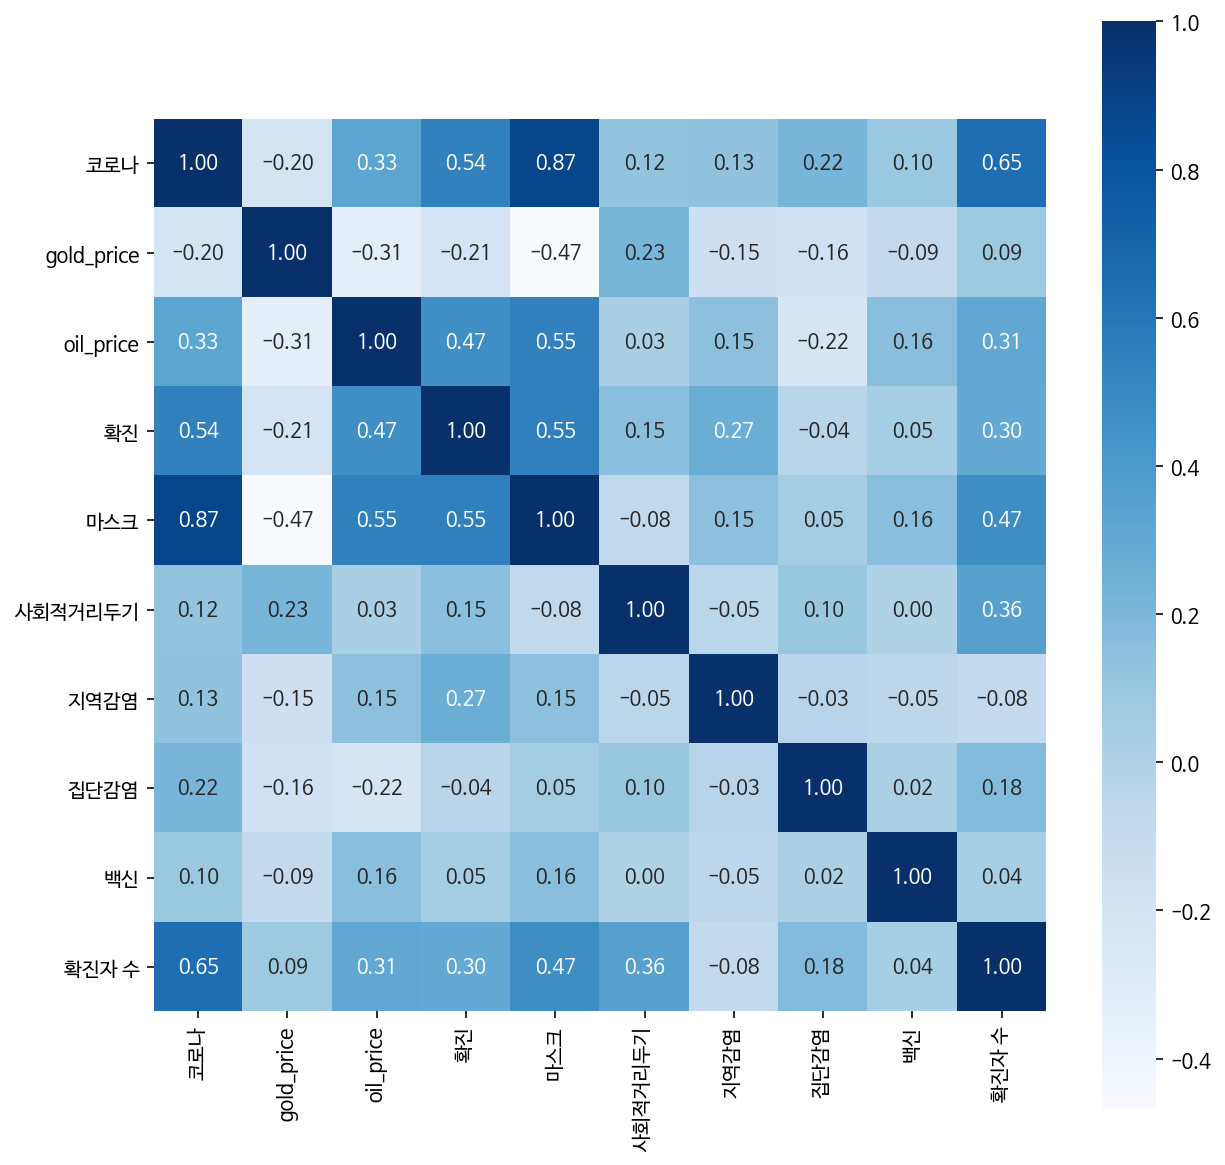

In [9]:
final_data2=final_data.drop('date',axis=1)

corr = final_data2.corr(method = 'pearson')
print(corr)
plt.figure(figsize=(10, 10))
df_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 10}, fmt = '.2f', square = True, cmap = 'Blues')

1. '코로나' 키워드, '마스크' 키워드, '확진'키워드, 실제 확진자 수 서로 상관성을 보이는 변수들

2. 실제 확진자 수와 '사회적 거리두기' 키워드 다소 상관성을 보임 (0.36)


In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(final_data2)
X=pd.DataFrame(X)

X.columns = ['코로나','gold_price','oil_price','확진','마스크','사회적거리두기','지역감염','집단감염','백신','확진자 수']

X['date']= final_data['date']

# 시각화

(1) '코로나' 키워드, '마스크' 키워드, '확진'키워드, 실제 확진자 수  -->  유사한 추세를 가짐


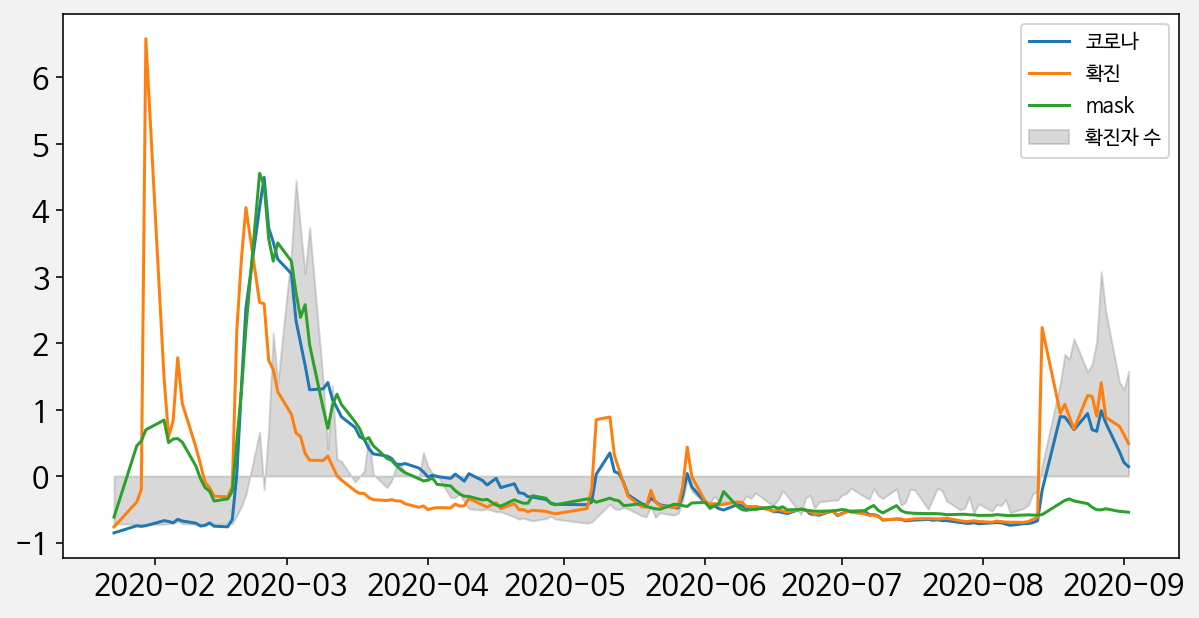

In [15]:
fig = plt.figure(figsize=(10, 5)) # StandardScaler
fig.set_facecolor('#f2f2f2')
plt.fill_between(X.date,X['확진자 수'],label='확진자 수',color='gray', alpha = 0.3)
plt.plot(X.date,X['코로나'],label='코로나')
plt.plot(X.date,X['확진'],label='확진') #코로나와 유사한 추세
plt.plot(X.date,X['마스크'],label='mask') #마스크에 대한 수요 하락
# plt.plot(X.date,X['백신'],label='vaccine')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend()

(2) 실제 확진자 수와 '사회적 거리두기' 키워드

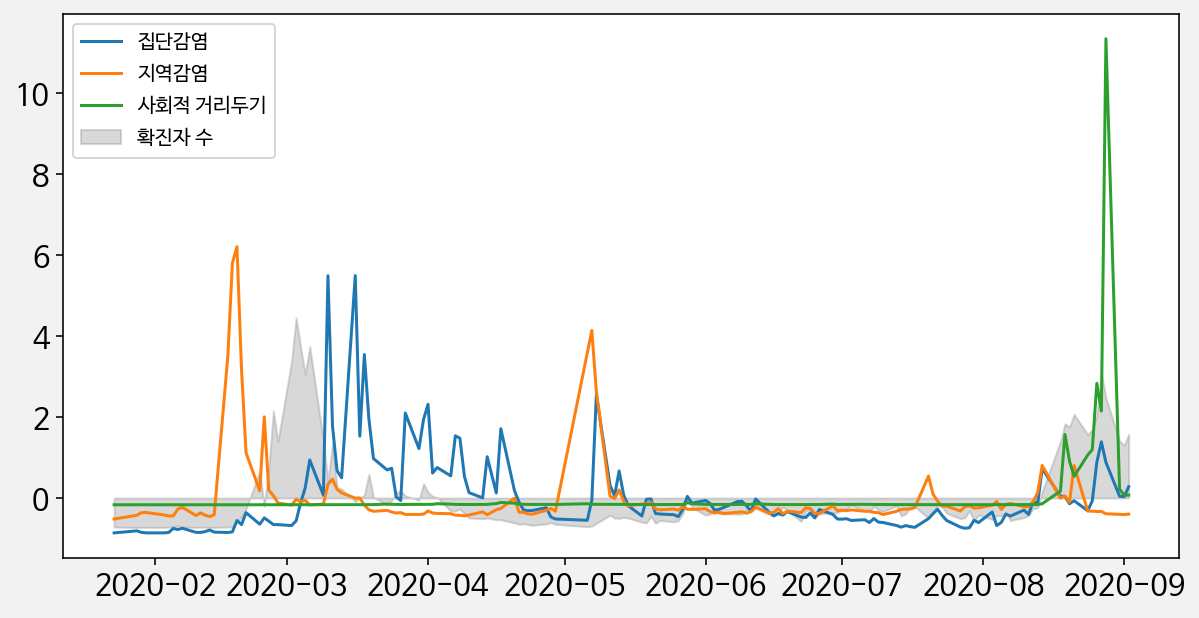

In [17]:
fig = plt.figure(figsize=(10, 5)) # StandardScaler
fig.set_facecolor('#f2f2f2')

# X.columns = ['코로나','gold_price','oil_price','확진','마스크','사회적거리두기','지역감염','집단감염','백신']
plt.fill_between(X.date,X['확진자 수'],label='확진자 수',color='gray',alpha=0.3)
# plt.plot(X.date,X['코로나'],label='corona')
plt.plot(X.date,X['집단감염'],label='집단감염')
plt.plot(X.date,X['지역감염'],label='지역감염')
plt.plot(X.date,X['사회적거리두기'],label='사회적 거리두기')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.legend()

# 2. 코로나 영향받는 업종
- KT, 데이콘 포스트 코로나 데이터 https://dacon.io/competitions/official/235618/overview/
- top 20, bottom 20

In [18]:
card_data=pd.read_csv('/content/drive/My Drive/코로나/corona_git/dataset/KT_data_20200717/card_20200717.csv')

In [19]:
from datetime import datetime

# mrhst_induty_cl_nm는 업종을, recipt_dttm은 월을, salamt는 총 소비금액

card=card_data[['receipt_dttm','mrhst_induty_cl_nm','salamt']]
col = list(set(card['mrhst_induty_cl_nm']))
col.sort()

category = ['숙박업','숙박업','방송','홈쇼핑','연료','송금','상품권','패션','가전','가전','요식','건강','건강','건축','서비스',
'운송','잡화','스포츠','스포츠','스포츠','공공요금','공공요금','매점/편의점','설비','관광','교육','매점/편의점','자동차','자동차',
'패션','설비','관광','교육','교육','운송','가구','건강','건축','설비','운송','농업','서비스','스포츠','보험','유통',
'문구','문구','기타','숙박업','연료','서비스','유통','요식','의료','의류','자동차','잡화','기기','기타','주방','의류',
'회원제','회원제','회원제','회원제','회원제','의류','기기','유흥','농업','식품','식품','유흥','의류','스포츠','교육',
'대형할인점','교육','동물','스포츠','스포츠','렌트','의류','면세점','문구','문화','미용','식품','미용','예술','법률','법률','의료',
'보관창고','교육','인테리어','스포츠','부동산','부동산','비영리','농업','기타','비영리','사무','사무','사무','사무','개인',
'사우나','서비스','의료','상품권','상품권','보험','요식','문구','잡화','자동차','생활','컴퓨터','보험','스포츠','문화','자동차',
'대형마트','스포츠','식품','스포츠','스포츠','스포츠','패션','패션','잡화','의류','예술','패션','패션','마사지','동물','약국',
'잡화','운송','문구','문화','교육','의류','의류','문구','교육','면세점','방송','급식업','설비','연료','교육','교육','교육(해외)',
'유흥','설비','의료','의료','미용','통신','자동차','건강','인터넷쇼핑','인터넷쇼핑','인터넷쇼핑','인테리어','가구','문구',
'백화점','요식','요식','자동차','자동차','자동차','자동차','백화점','기타','장례','연료','문구','상우회','상품권(전자상)',
'상품권(전자상)','가전','식품','정기간행물','정보','의류','패션','식품','의료','가전','의료','조세','조세','스포츠','의료',
'용역','연료','자동차','주류','주방','주방','주점','자동차','자동차','요식','건축','운송','가구','교육','총포류','인쇄','의료',
'의료','생활','문화','자동차','카지노','주점','의류','컴퓨터','교육','숙박업','운송','운송','스포츠','통신','통신','통신','통신',
'통신','통신','통신','통신','숙박업','문화','인테리어','매점/편의점','미용','예술','교육','교육','의료','의료','의료','요식',
'항공','스포츠','혼례','혼례','건강','예술','문화','미용','유통','예술'
]

d= {} 
for i in range(260):
    d[col[i]] = category[i]


sales = card.groupby(['mrhst_induty_cl_nm','receipt_dttm']).sum()['salamt'].reset_index()
sales.mrhst_induty_cl_nm = sales.mrhst_induty_cl_nm.replace(d)
sales.receipt_dttm = [datetime.strptime(str(x),'%Y%m%d').month for x in sales.receipt_dttm]
sales = sales.groupby(['mrhst_induty_cl_nm','receipt_dttm']).sum()['salamt'].reset_index()
sales = sales[sales.receipt_dttm !=6]
remove = ['공공요금','개인','기타','비영리','상우회','정보','회원제','총포류','카지노','송금','조세','농업','설비']
sales = sales[~sales.mrhst_induty_cl_nm.isin(remove)]
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 419
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   mrhst_induty_cl_nm  300 non-null    object
 1   receipt_dttm        300 non-null    int64 
 2   salamt              300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 9.4+ KB


In [20]:
top20 = sales.pivot_table(values='salamt',index='mrhst_induty_cl_nm').reset_index().sort_values('salamt',ascending=False).head(20)
top20.reset_index(drop=True, inplace=True)
top20['salamt'] = top20['salamt']
top20=top20.sort_values('salamt',ascending=True)

bottom20 = sales.pivot_table(values='salamt',index='mrhst_induty_cl_nm').reset_index().sort_values('salamt',ascending=True).head(20)
bottom20.reset_index(drop=True, inplace=True)
bottom20=bottom20.sort_values('salamt',ascending=False)

# 시각화

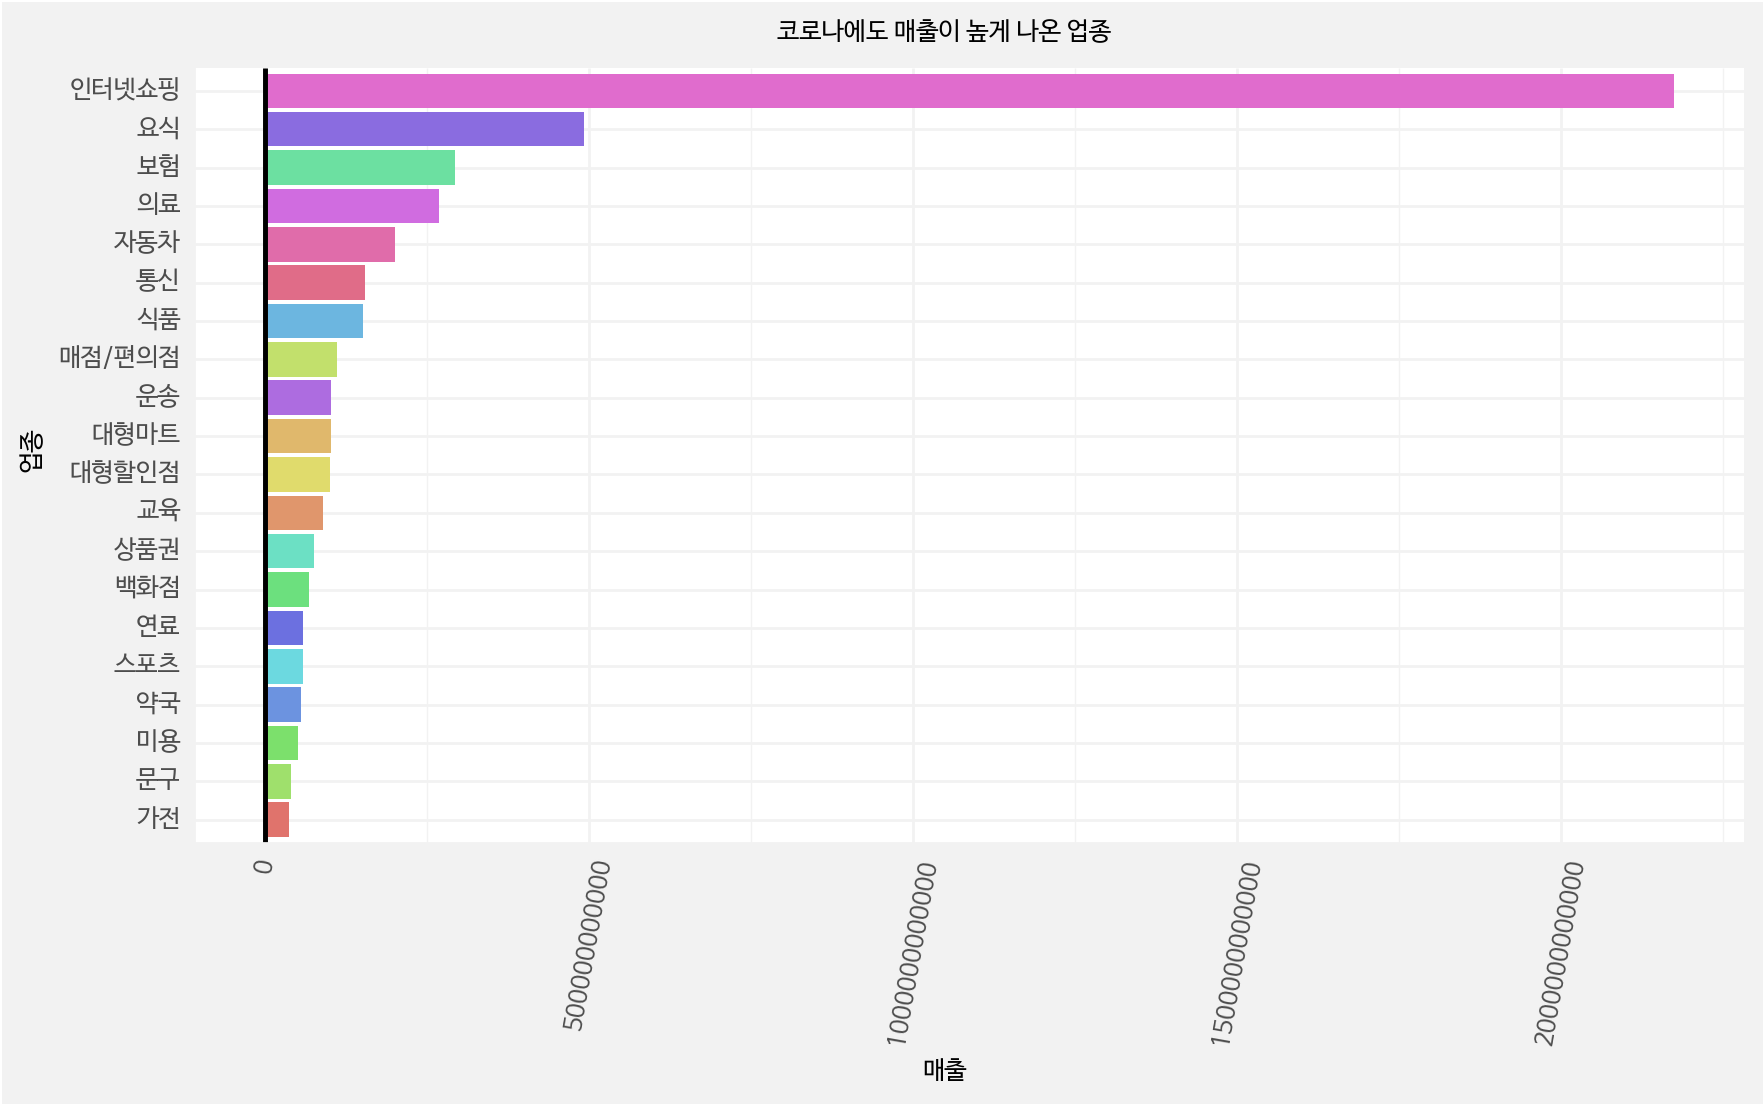

<ggplot: (8783700088566)>

In [109]:
a = (ggplot(data=top20,mapping=aes(x='mrhst_induty_cl_nm',y='salamt'))
+geom_bar(stat='identity',mapping =aes(fill='mrhst_induty_cl_nm'),show_legend=False)
+theme(figure_size=(5,5),axis_text_x=element_text(size=13,angle=80))
+geom_hline(yintercept=0,size=1)
+ggtitle('코로나에도 매출이 높게 나온 업종')
+scale_fill_hue(l=0.65)
+ theme(text=element_text(fontproperties=font))
+ coord_flip()
+xlab("업종") + ylab("매출")
+ scale_x_discrete(limits = top20.mrhst_induty_cl_nm))

a + theme(
    panel_background=element_rect(fill='white'),
    line=element_line(color='#f2f2f2'),
    #dpi=120,
    figure_size=(10, 4), # inches
    aspect_ratio=1/2,    # height:width,
    plot_background=element_rect(fill='#f2f2f2'),
)

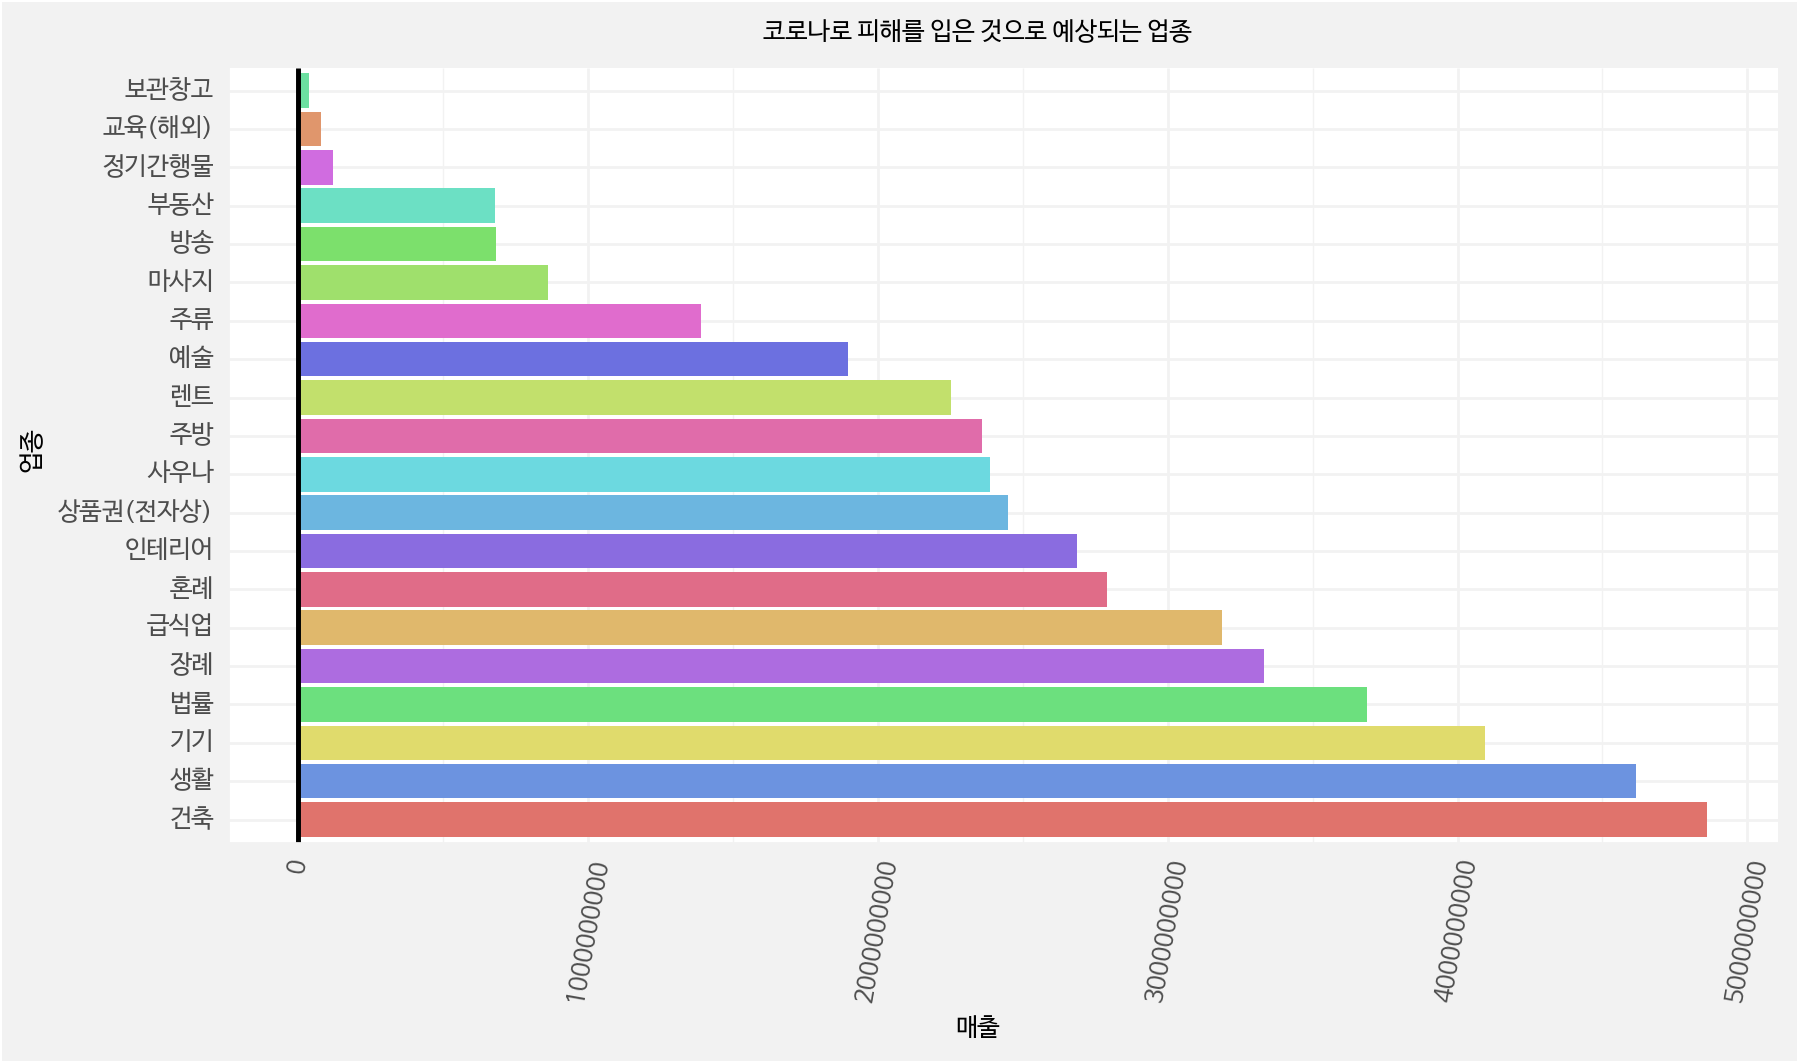

<ggplot: (8783697237701)>

In [110]:
a = (ggplot(data=bottom20,mapping=aes(x='mrhst_induty_cl_nm',y='salamt'))
+geom_bar(stat='identity',mapping =aes(fill='mrhst_induty_cl_nm'),show_legend=False)
+theme(figure_size=(5,5),axis_text_x=element_text(size=13,angle=80))
+geom_hline(yintercept=0,size=1)
+ggtitle('코로나로 피해를 입은 것으로 예상되는 업종')
+scale_fill_hue(l=0.65)
+ theme(text=element_text(fontproperties=font),)
+ coord_flip()
+xlab("업종") + ylab("매출") 
+ scale_x_discrete(limits = bottom20.mrhst_induty_cl_nm))

a + theme(
    panel_background=element_rect(fill='white'),
    line=element_line(color='#f2f2f2'),
    #dpi=120,
    figure_size=(10, 4), # inches
    aspect_ratio=1/2,    # height:width,
    plot_background=element_rect(fill='#f2f2f2'),
    
)

# 3. 사회적 거리두기 - 코로나 이후 지하철 이용량 시각화
- 서울교통공사 데이터
- 금요일, 토요일 빈도 낮아짐
- 지하철 이용량 하락 o

In [23]:
subway20=pd.read_csv(r'/content/drive/My Drive/코로나/corona_git/dataset/seoul_data/서울교통공사_1_8호선일별역별시간대별승하차인원_202001_202005.csv',encoding='euc-kr')

subway19=pd.read_excel(r'/content/drive/My Drive/코로나/corona_git/dataset/seoul_data/2019년 1월_12월 역별 시간대별 승하차인원.xlsx',header=1)


subway19_select=subway19[['날짜','호선','역번호','역명','24시 이후','합 계']]
subway20_select=subway20[['날짜','호선','역번호','역명','24시 이후','합 계']]

subway19_select['날짜']=pd.to_datetime(subway19_select['날짜'])
subway20_select['날짜']=pd.to_datetime(subway20_select['날짜'])


In [24]:
subway20_total=pd.pivot_table(subway20_select, index='날짜',values='합 계',aggfunc=np.sum)
subway20_total.reset_index(inplace=True)
subway19_total=pd.pivot_table(subway19_select, index='날짜',values='합 계',aggfunc=np.sum)
subway19_total.reset_index(inplace=True)

subway20_total.columns=['date','subway_count']
subway19_total.columns=['date','subway_count']

total=pd.concat([subway19_total, subway20_total])
total_sub=total[(total['date'] >= '2019-05-01')]
total_sub.reset_index(drop=True,inplace=True)



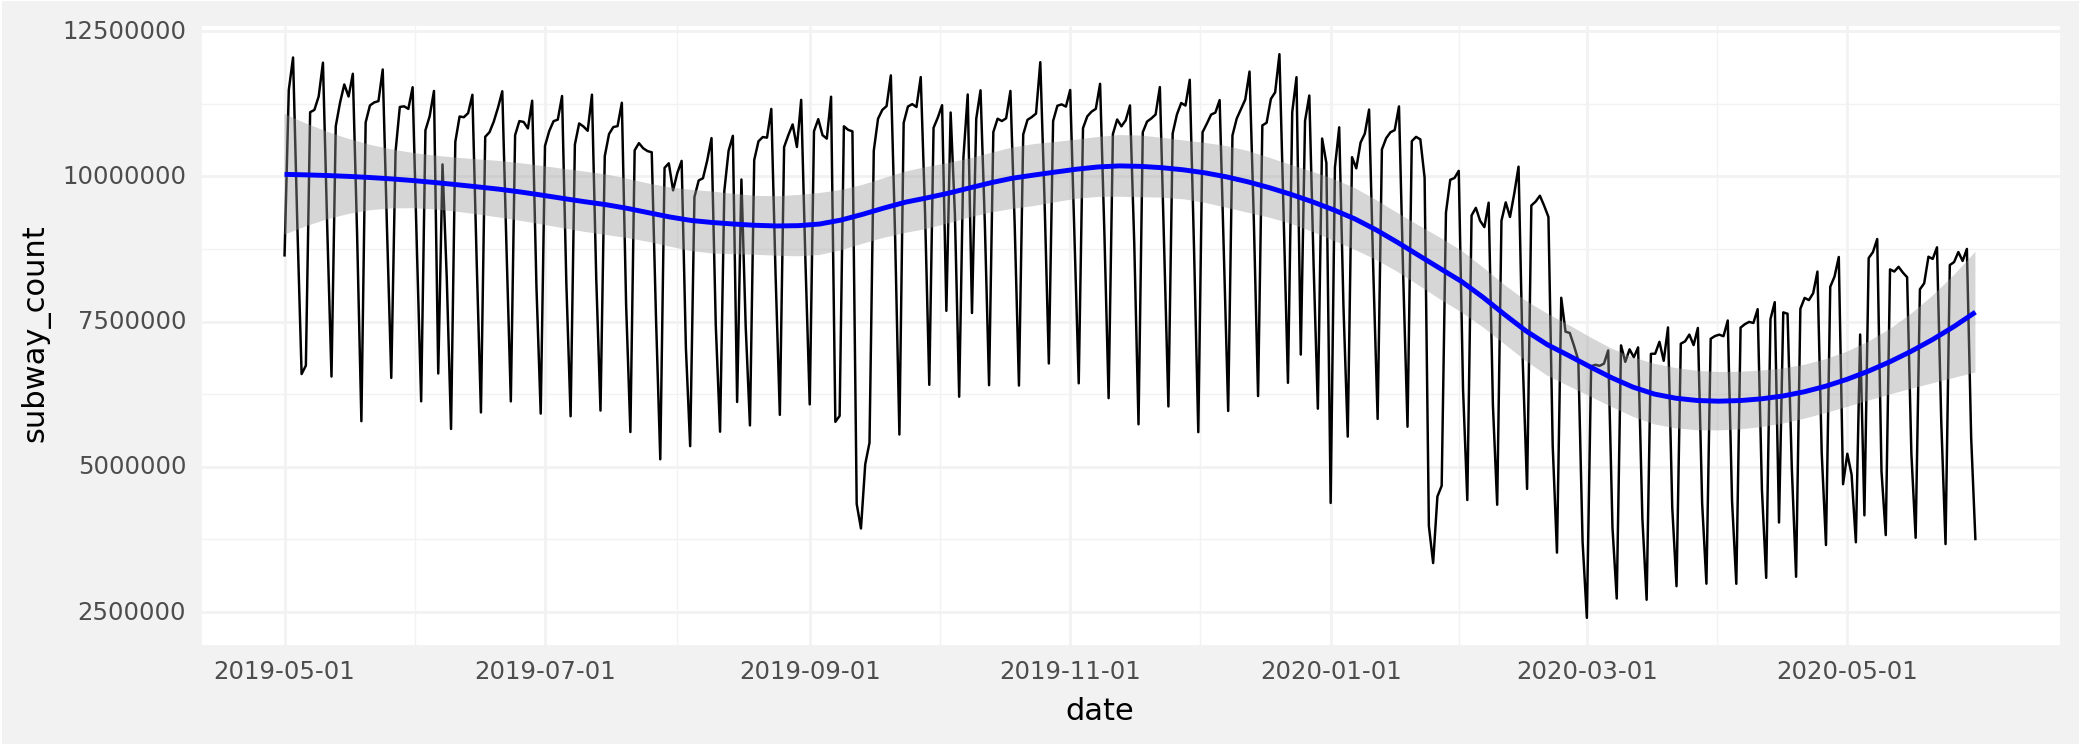

<ggplot: (8783696952980)>

In [111]:
p = (ggplot(aes(x='date', y='subway_count'), data=total_sub) +\
    geom_line() +\
    stat_smooth(colour='blue', span=0.4))

p + theme(
    panel_background=element_rect(fill='white'),
    line=element_line(color='#f2f2f2'),
    #dpi=120,
    figure_size=(12, 10), # inches
    aspect_ratio=1/3,    # height:width
    plot_background=element_rect(fill='#f2f2f2')
    
)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


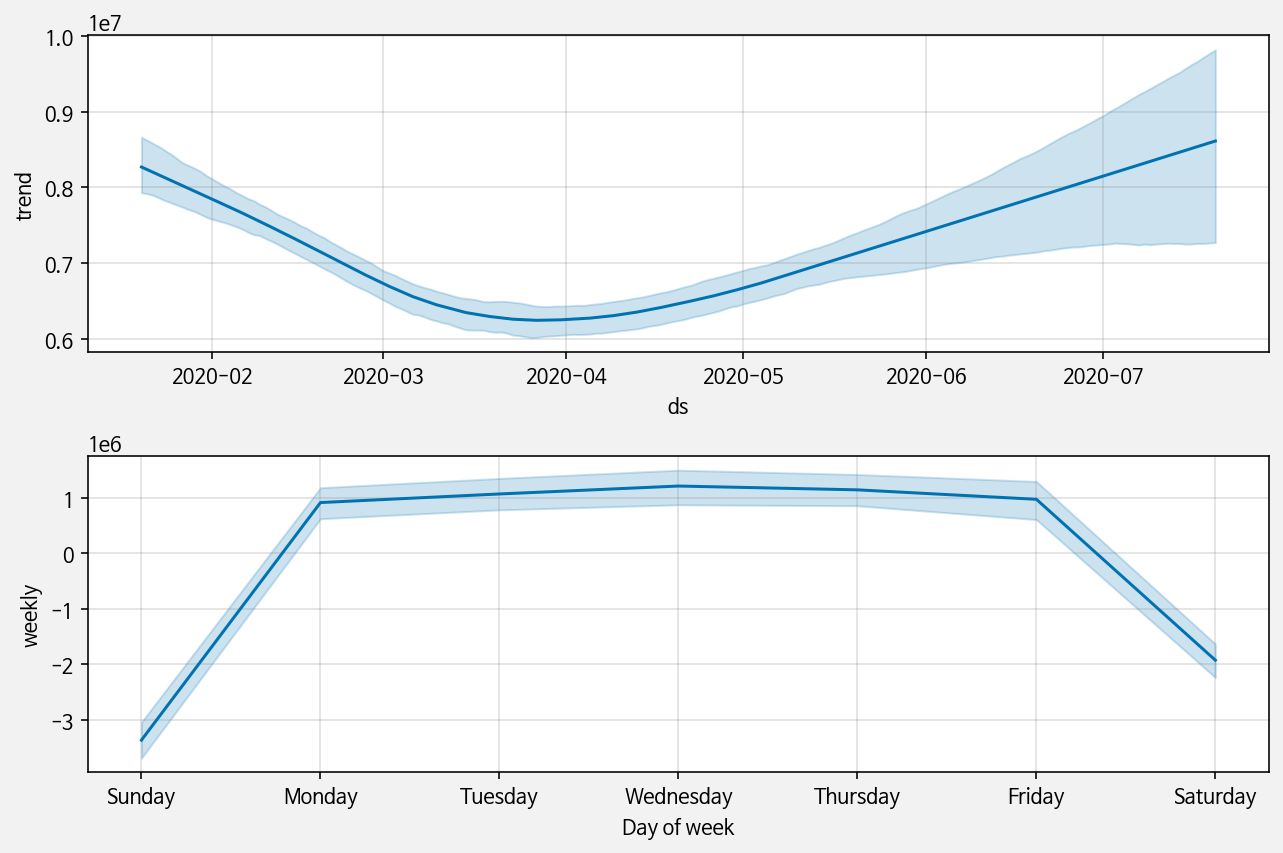

In [71]:
after_sub=total[(total['date'] >= '2020-01-20')]
after_sub.reset_index(drop=True,inplace=True)

distance_prophet = after_sub.rename(columns={'date': 'ds','subway_count': 'y'})
distance_prophet.head()
m=Prophet()
m.fit(distance_prophet)
future=m.make_future_dataframe(periods=50)
forecast = Prophet(interval_width=0.95).fit(distance_prophet).predict(future)
#시즈널리티의 불확실성을 알기 위해 베이지안 샘플링을 사용해야 함,mcmc.samples 파라미터를 사용. 이 값을 사용하면 최초 n일에 대해 적용한다는 뜻
m = Prophet(mcmc_samples=62)
forecast = m.fit(distance_prophet).predict(future)
fig = m.plot_components(forecast)
fig.set_facecolor('#f2f2f2')

# 코로나가 없었다면 지하철 이용량 예측
- 금요일, 토요일 빈도 높음
- 지하철 이용량 하락 x

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


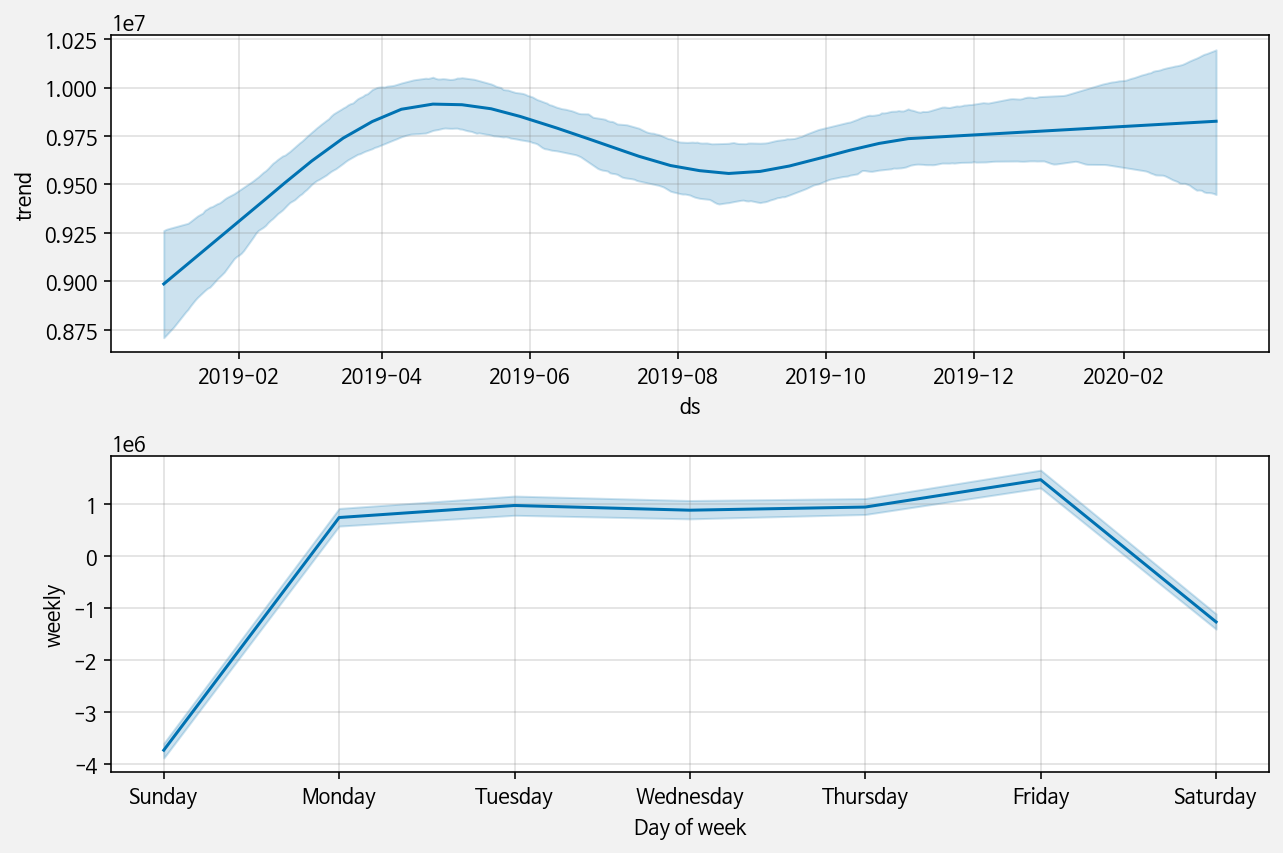

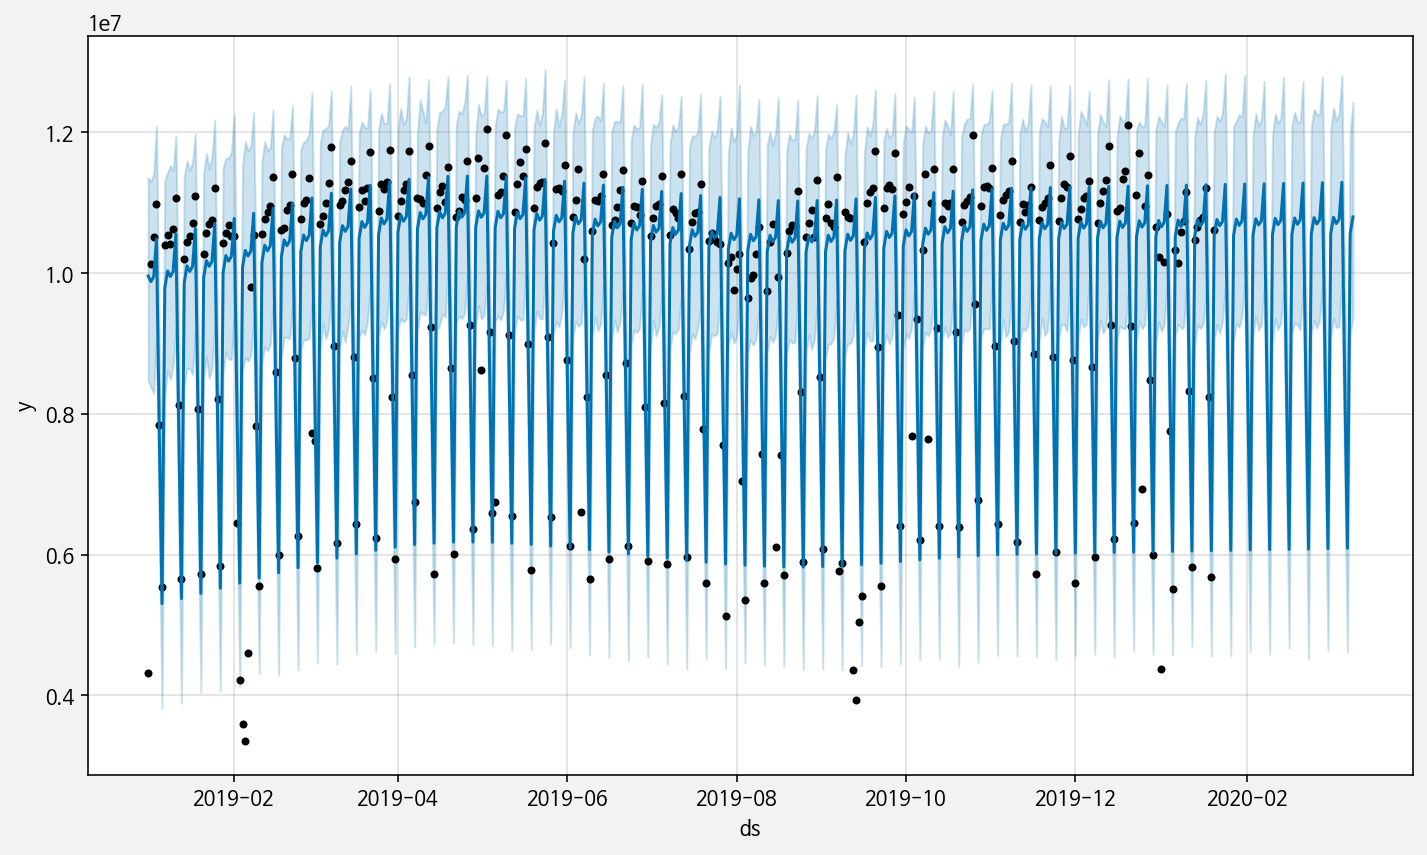

In [86]:
before_sub=total[(total['date'] <= '2020-01-20')]
before_sub.reset_index(drop=True,inplace=True)

distance_prophet = before_sub.rename(columns={'date': 'ds','subway_count': 'y'})
distance_prophet.head()
m=Prophet()
m.fit(distance_prophet)

#예측할 미래 dataframe 만들기
future=m.make_future_dataframe(periods=50)

#불확실성의 범위 보기
forecast = Prophet(interval_width=0.95).fit(distance_prophet).predict(future)
#시즈널리티의 불확실성을 알기 위해 베이지안 샘플링을 사용해야 함,mcmc.samples 파라미터를 사용. 이 값을 사용하면 최초 n일에 대해 적용한다는 뜻
m = Prophet(mcmc_samples=62)
forecast = m.fit(distance_prophet).predict(future)
fig = m.plot_components(forecast)
fig.set_facecolor('#f2f2f2')


fig = m.plot(forecast)#파란선
fig.set_facecolor('#f2f2f2')

# a = add_changepoints_to_plot(fig.gca(), m, forecast)#빨간 선 나타내기


# 4. 9월 4일까지 확진자 시각화

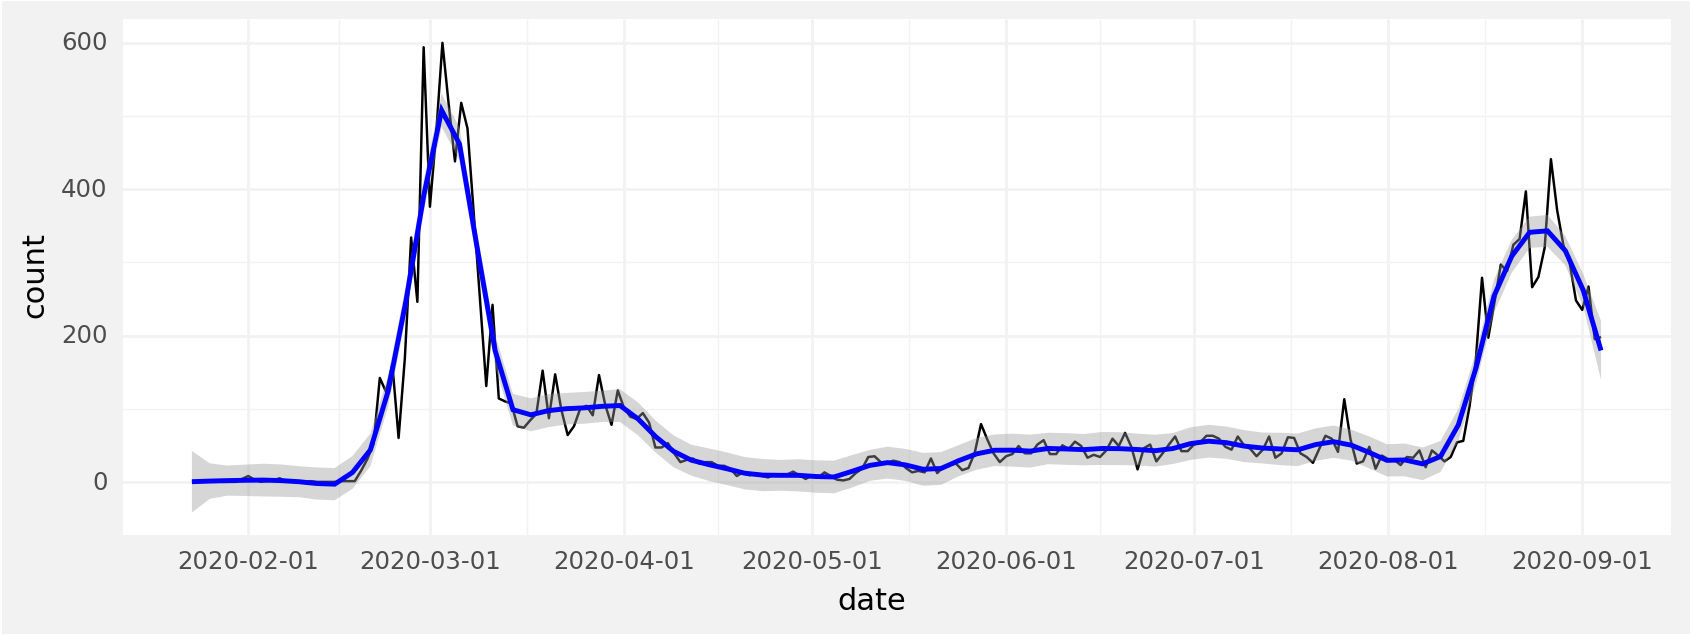

<ggplot: (-9223363253148332505)>

In [114]:
p = (ggplot(aes(x='date', y='count'), data=recent_corona) +\
    geom_line() +\
    stat_smooth(colour='blue', span=0.1))

p + theme(
    panel_background=element_rect(fill='white'),
    line=element_line(color='#f2f2f2'),
    #dpi=120,
    figure_size=(10, 8), # inches
    aspect_ratio=1/3,   # height:width
    plot_background=element_rect(fill='#f2f2f2')
)


# 교회 및 집회 집단 감염이 없었다면 (8월 15일 전후)

- 확산 진정

In [116]:
import pandas as pd
import numpy as np
import datetime
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [117]:
test = recent_corona[recent_corona.date > '2020-08-15'].reset_index(drop=True)
train = recent_corona[recent_corona.date <= '2020-08-15'].reset_index(drop=True)

In [118]:
distance_prophet = train.rename(columns={'date': 'ds','count': 'y'})
distance_prophet.head()
m=Prophet()
m.fit(distance_prophet)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


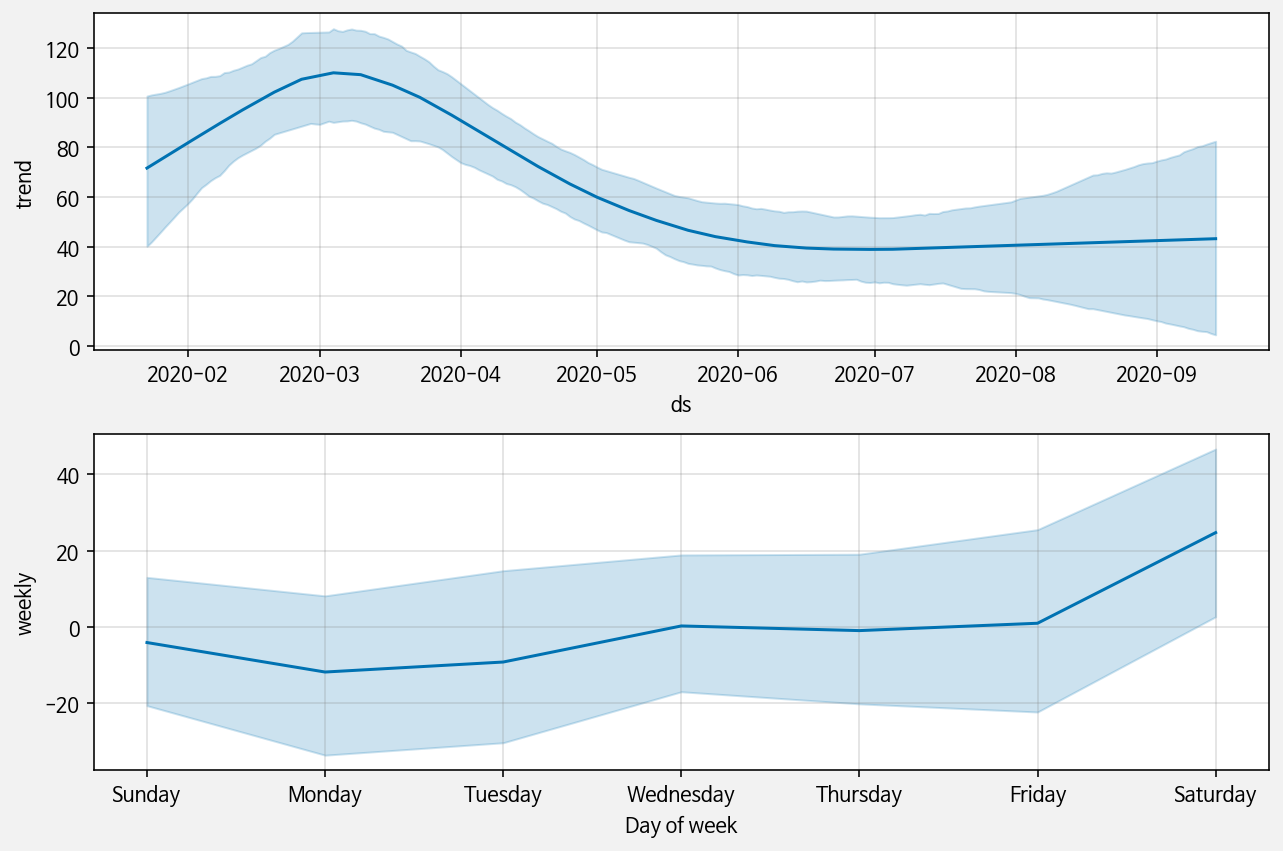

In [119]:
#예측할 미래 dataframe 만들기
future=m.make_future_dataframe(periods=30)

#불확실성의 범위 보기
forecast = Prophet(interval_width=0.95).fit(distance_prophet).predict(future)
#시즈널리티의 불확실성을 알기 위해 베이지안 샘플링을 사용해야 함,mcmc.samples 파라미터를 사용. 이 값을 사용하면 최초 n일에 대해 적용한다는 뜻
m = Prophet(mcmc_samples=62)
forecast = m.fit(distance_prophet).predict(future)
fig = m.plot_components(forecast)
fig.set_facecolor('#f2f2f2')


In [120]:
# m.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


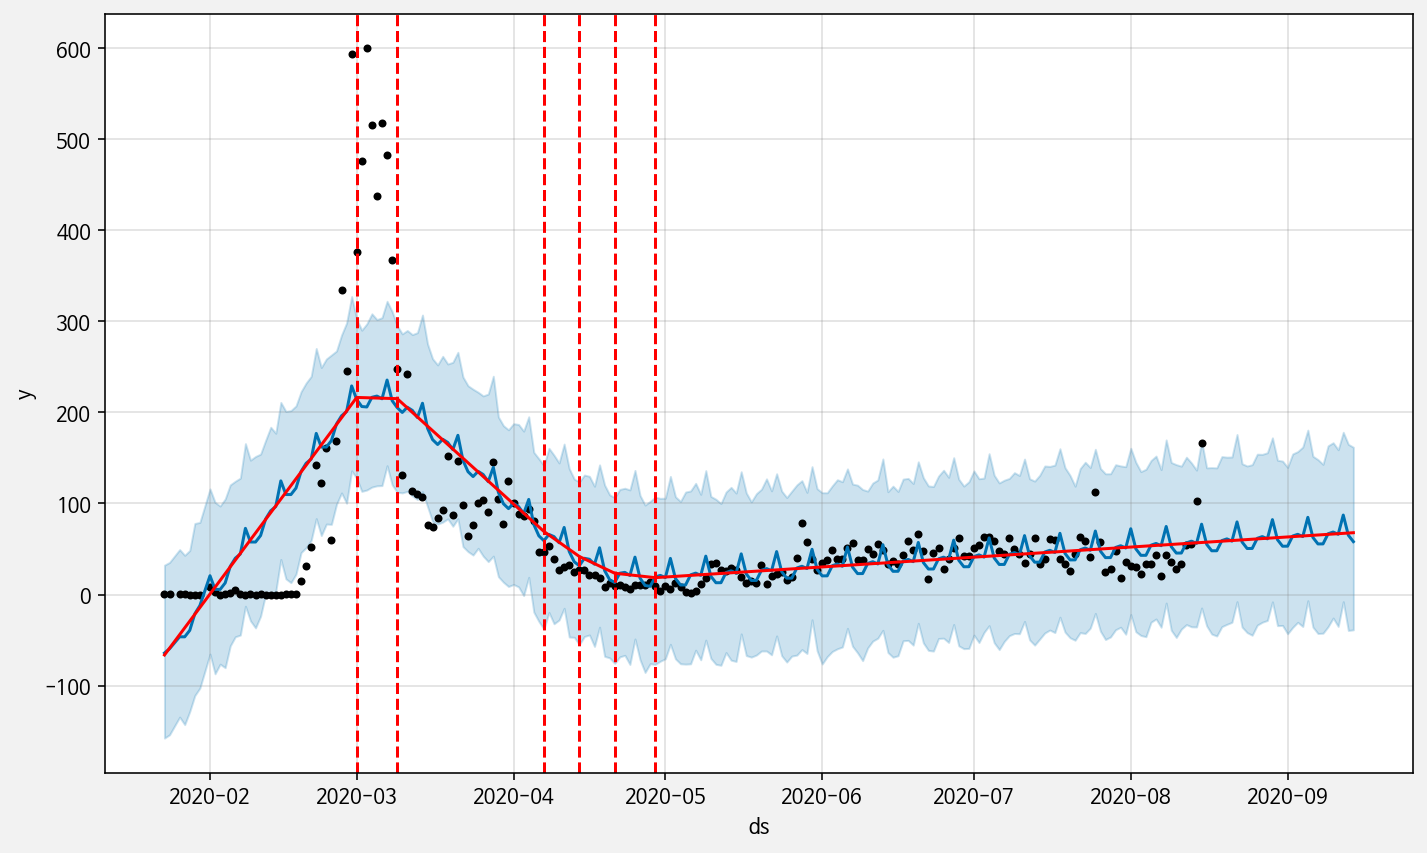

In [121]:
m = Prophet(
    changepoint_prior_scale=0.2, # increasing it will make the trend more flexible 디폴트는 0.05
    changepoint_range=0.9, # place potential changepoints in the first 98% of the time series
    
)

m.fit(distance_prophet)

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
# py.iplot(fig)

fig = m.plot(forecast)#파란선
fig.set_facecolor('#f2f2f2')


fig = add_changepoints_to_plot(fig.gca(), m, forecast)#빨간 선 나타내기